In [1]:
%matplotlib notebook
import geopandas as gpd
import pandas as pd
import os
import matplotlib.pyplot as plt
import shapely
import time
import networkx as nx
import numpy as np
from tqdm import tqdm

In [5]:
# read the directory with the shapefile data
europe_gpd = gpd.read_file("./databases/groads-v1-europe-shp/")
europe_gpd

OSError: no such file or directory: './databases/groads-v1-europe-shp/'

In [ ]:
# read the directory with the shapefile data
ocean_df = gpd.read_file("./databases/groads-v1-oceania-east-shp/")
ocean_df.plot()
plt.show()

In [ ]:
# the categories used in reduced datasets
cats = ["RoadID", "FClass", "Crgway", "NumLanes", "SpeedLimit", "GnralSpeed", "LENGTH_KM"]

# (minx, miny, maxx, maxy)
AUSTRALIA_BOUNDS = [112.0, -39.7, 154.0, -12.3]
AUS_TEST_BOUNDS = [117, -34, 119, -32]
def in_boundary(line, b):
    lb = line.bounds
    if  lb[0] < b[0] or\
        lb[1] < b[1] or\
        lb[2] > b[2] or\
        lb[3] > b[3]:
        return False
    else:
        return True

australia_df = ocean_df.loc[ocean_df['geometry'].apply(in_boundary, args=[AUSTRALIA_BOUNDS])]
small_df = ocean_df.loc[ocean_df['geometry'].apply(in_boundary, args=[AUS_TEST_BOUNDS])]

In [ ]:
start_intersects = time.time()
small_intersects = []
# check for each line, all intersections with all other lines
for i1, line1 in small_df['geometry'].iteritems():
    for i2, line2 in small_df['geometry'].iteritems():
        if i1 <= i2:
            # if i1 == i2: the intersection is the entire (Multi)LineSegment (whole road)
            # any other intersection is a Point (transition from one road to another)
            intersects = line1.intersection(line2)
            if not intersects.is_empty:
                small_intersects.append(intersects)

end_intersects = time.time()
print ('Time to fit:', (end_intersects-start_intersects)/60.)
print ("Number of intersections:", len(small_intersects))

In [ ]:
# plot either single line or point
def plot_segment(ob, c):
    x, y = ob.xy
    if len(x) == 1:
        plt.plot(x, y, 'o', color=c, zorder=2)
    else:
        plt.plot(x, y, color=c, alpha=1.0, linewidth=3, solid_capstyle='round', zorder=1)

# plot all the lines separately
# small_df.plot()

# plot the intersections
for intersect in small_intersects:
#     print type(intersect)
    rcolor = np.random.rand(3,)
    if isinstance(intersect, shapely.geometry.multilinestring.MultiLineString):
        # this is a line consisting of multiple smaller lines
        for ob in intersect:
            plot_segment(ob, rcolor)
    elif isinstance(intersect, shapely.geometry.linestring.LineString):
        # this is a single line
        plot_segment(intersect, rcolor)
    elif isinstance(intersect, shapely.geometry.point.Point):
        # this is a single point
        plot_segment(intersect, 'r')
    else:
        print("Something odd happend, call Patrick!")
        
plt.show()

In [ ]:
# adds a candidate to the crossings list if not already present
# returns the index of the candidate
def crossing_index(crossings, candidate):
    # set the index as the newest position
    index = len(crossings)
    try:
        # replace if already in the list
        index = crossings.index(candidate)
    except ValueError:
        # add to the list at the last index
        crossings.append(candidate)
    return index

    # this might be fast (consider testing pls)
#     if candidate in crossings:
#         return crossings.index(candidate)
#     else:
#         crossings.append(candidate)
#         return len(crossings)


# make a networkx graph
G=nx.Graph()

MAX_ROAD_LEN = 50
MIN_COLOR = 0.3
# contains coordinates as values
crossings = []
# contains [crossing_index1, crossing_index2, length] as values
roads = [] #it is not used tho, only useful for testing
# completely built on the idea that there is no crossing within a road
# crossings only occur at the ends of the road (a new road starts after the crossing)
for global_index, road_attrs in tqdm(australia_df.iterrows()):
    line = road_attrs['geometry']
    length = road_attrs['LENGTH_KM']
    road_points = list(line.coords)
    # the roads begin and end coordinateIDs
    beginID = crossing_index(crossings, road_points[0])
    endID = crossing_index(crossings, road_points[-1])
    # add the new road between the crossings
    roads.append([beginID, endID, length])
    
    # transform the length of the road to some value between MIN_COLOR and 1
    length_as_color = length/float(MAX_ROAD_LEN)*(1.-MIN_COLOR)+MIN_COLOR
    length_as_color = min(length_as_color, 1)
    # add the roads as edges to the network
    G.add_edge(beginID, endID, weight=length_as_color, ROADID = road_attrs["ROADID"], FCLASS = road_attrs["FCLASS"],
                CRGWAY = road_attrs["CRGWAY"], NUMLANES = road_attrs["NUMLANES"], SPEEDLIMIT = road_attrs["SPEEDLIMIT"],
              GNRALSPEED = road_attrs["GNRALSPEED"])
           

plt.figure()
# list of all edges
edges = [(u,v) for (u,v,d) in G.edges(data=True)]
# positions for all nodes
pos = dict(enumerate(crossings))
#nx.set_node_attributes(G, 'coord', pos)

# nodes
nx.draw_networkx_nodes(G,pos = pos, node_size=1, node_color='r', node_shape='v')

# colour edges based on their weights
edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())
nx.draw_networkx_edges(G, pos = pos, edgelist=edges, edge_color=weights, width=1, edge_cmap=plt.cm.Blues)
#nx.draw(G, pos = pos)

#small_df.plot()
plt.show()

In [ ]:
nx.set_node_attributes(G, pos, "coords")
nx.write_gpickle(G, "databases/australia")

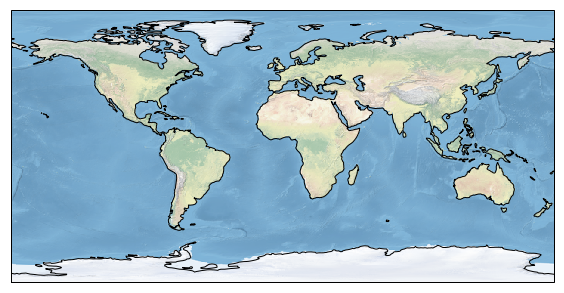

In [13]:

import matplotlib.pyplot as plt

import cartopy
import cartopy.crs as ccrs


fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# make the map global rather than have it zoom in to
# the extents of any plotted data
ax.set_global()
ax.stock_img()
ax.coastlines()

plt.show()


print (cartopy.feature.COASTLINE)
    
